# Clustering the Dataset

In [49]:
import warnings
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from gower import gower_matrix
from kmodes.kprototypes import KPrototypes
import matplotlib.pyplot as plt
import umap
import hdbscan
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from kmodes.kprototypes import KPrototypes

from clustering.kprototype import kprototype
from clustering.gmm import gmm_cluster
from clustering.hdbscan import hdbscan_cluster
from clustering.spectral import spectral_cluster

warnings.filterwarnings('ignore')

## 1. Load the Dataset

In [50]:
ilpd_indian_liver_patient = fetch_ucirepo(id=225)

X = ilpd_indian_liver_patient.data.features
y = ilpd_indian_liver_patient.data.targets

clusters_df = pd.DataFrame()

X = X.dropna()

In [51]:
X

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40
...,...,...,...,...,...,...,...,...,...,...
578,60,Male,0.5,0.1,500,20,34,5.9,1.6,0.37
579,40,Male,0.6,0.1,98,35,31,6.0,3.2,1.10
580,52,Male,0.8,0.2,245,48,49,6.4,3.2,1.00
581,31,Male,1.3,0.5,184,29,32,6.8,3.4,1.00


## 2. Preprocessing

In [52]:
X.isna().sum() # Check for missing values (there's none)

Age          0
Gender       0
TB           0
DB           0
Alkphos      0
Sgpt         0
Sgot         0
TP           0
ALB          0
A/G Ratio    0
dtype: int64

In [53]:
# Build preprocessing pipeline

numeric_features = ['Age', 'TB', 'DB', 'Alkphos', 'Sgpt', 'Sgot', 'TP', 'ALB', 'A/G Ratio']
categorical_features = ['Gender']
all_columns = numeric_features + categorical_features

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features), # RobustScaler?
        #('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough',
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [54]:
X_scaled = pipeline.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=all_columns, index=X.index)

# Convert numeric to float explicitly
X_scaled[numeric_features] = X_scaled[numeric_features].astype(float)

# Convert categorical to string explicitly
X_scaled[categorical_features] = X_scaled[categorical_features].astype(str)

#X_scaled

In [55]:
X_numeric = X[numeric_features] # Remove Gender (temporarily)
X_scaled_numeric = X_scaled[numeric_features]

#X_scaled_numeric

## 3. Clustering using K-Prototype

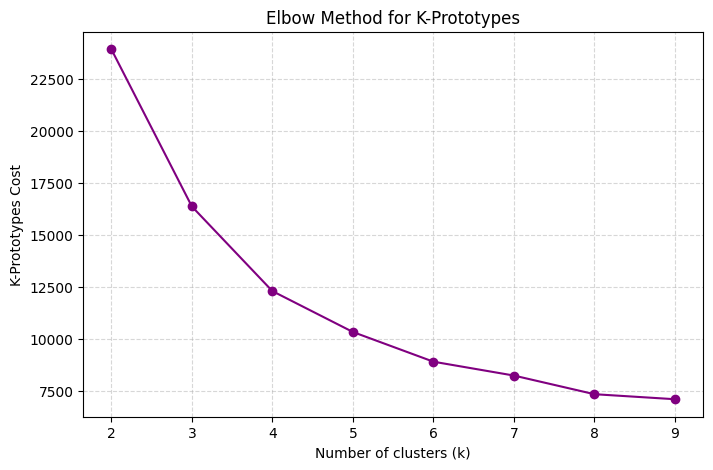

In [56]:
ks = range(2, 10)
costs = []
clusters = dict()

for k in ks:
    labels, model, sil = kprototype(X_scaled, k)
    costs.append(model.cost_)
    clusters[k] = labels

plt.figure(figsize=(8,5))
plt.plot(ks, costs, marker='o', linestyle='-', color='purple')
plt.xlabel('Number of clusters (k)')
plt.ylabel('K-Prototypes Cost')
plt.title('Elbow Method for K-Prototypes')
plt.xticks(ks)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [57]:
best_ks = [2, 4, 5]

for k in best_ks:
    clusters_df[f'Clusters_KProto_k{k}'] = clusters[k]

## 4. Clustering using GMM

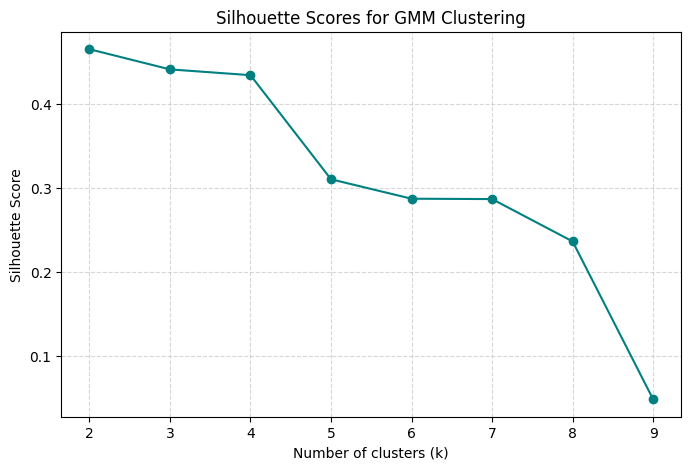

In [58]:
ks = range(2, 10)
clusters = dict()
silhouette_scores = []

for k in ks:
    labels, model, sil = gmm_cluster(X_scaled_numeric, k)
    clusters[k] = labels
    silhouette_scores.append(sil)

ks = [k for k in ks]

# Plot
plt.figure(figsize=(8,5))
plt.plot(ks, silhouette_scores, marker='o', linestyle='-', color='teal')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for GMM Clustering')
plt.xticks(ks)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [59]:
best_ks = [2, 4, 7]

for k in best_ks:
    clusters_df[f'Clusters_GMM_k{k}'] = clusters[k]

## 5. Clustering with HDBSCAN

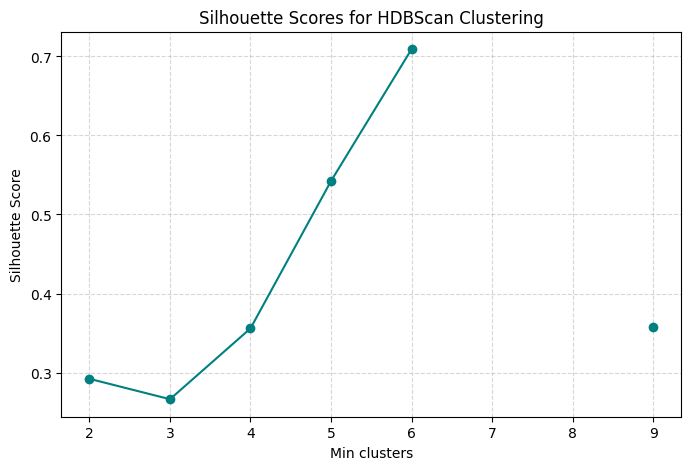

In [60]:
min_clusters = range(2, 10)
clusters = dict()
silhouette_scores = []

for min_cluster in min_clusters:
    labels, model, sil = hdbscan_cluster(X_scaled_numeric, min_cluster)
    clusters[min_cluster] = labels
    silhouette_scores.append(sil)

min_clusters = [min_cluster for min_cluster in min_clusters]

# Plot
plt.figure(figsize=(8,5))
plt.plot(min_clusters, silhouette_scores, marker='o', linestyle='-', color='teal')
plt.xlabel('Min clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for HDBScan Clustering')
plt.xticks(ks)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [61]:
best_min_clusters = [5, 6]

for min_cluster in best_min_clusters:
    clusters_df[f'Clusters_HDBScan_MinClusters{min_cluster}'] = clusters[min_cluster]

## 7. Spectral Clustering

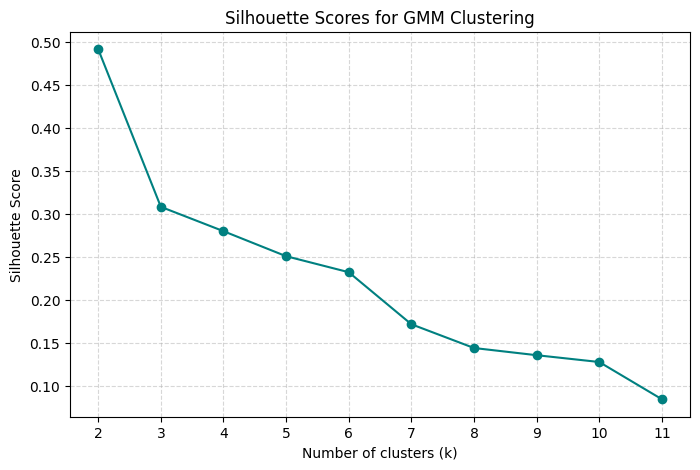

In [62]:
ks = range(2, 12)
clusters = dict()
silhouette_scores = []

for k in ks:
    labels, model, sil = spectral_cluster(X, k)
    clusters[k] = labels
    silhouette_scores.append(sil)

ks = [k for k in ks]

# Plot
plt.figure(figsize=(8,5))
plt.plot(ks, silhouette_scores, marker='o', linestyle='-', color='teal')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for GMM Clustering')
plt.xticks(ks)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [63]:
best_ks = [2, 4, 6]

for k in best_ks:
    clusters_df[f'Clusters_Spectral_k{k}'] = clusters[k]

In [64]:
clusters_df

,Clusters_KProto_k2,Clusters_KProto_k4,Clusters_KProto_k5,Clusters_GMM_k2,Clusters_GMM_k4,Clusters_GMM_k7,Clusters_HDBScan_MinClusters5,Clusters_HDBScan_MinClusters6,Clusters_Spectral_k2,Clusters_Spectral_k4,Clusters_Spectral_k6
0,0,1,0,0,0,0,1,0,1,1,0
1,0,0,3,0,1,1,-1,-1,0,2,2
2,0,1,0,0,1,1,-1,0,0,3,3
3,0,1,0,0,0,0,1,0,0,3,3
4,0,1,0,0,0,1,1,0,0,3,5
...,...,...,...,...,...,...,...,...,...,...,...
574,0,1,0,0,1,1,1,0,0,3,5
575,0,1,0,0,0,0,1,0,0,0,4
576,0,1,0,0,0,0,1,0,0,3,3
577,0,1,0,0,0,0,1,0,0,0,1


In [65]:
# Merge everything into a single DF

full_df = X.copy()
full_df[clusters_df.columns] = clusters_df.values
full_df['Label'] = y

full_df

,Age,Gender,TB,DB,Alkphos,Sgpt,Sgot,TP,ALB,A/G Ratio,...,Clusters_KProto_k5,Clusters_GMM_k2,Clusters_GMM_k4,Clusters_GMM_k7,Clusters_HDBScan_MinClusters5,Clusters_HDBScan_MinClusters6,Clusters_Spectral_k2,Clusters_Spectral_k4,Clusters_Spectral_k6,Label
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,...,0,0,0,0,1,0,1,1,0,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,...,3,0,1,1,-1,-1,0,2,2,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,...,0,0,1,1,-1,0,0,3,3,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,...,0,0,0,0,1,0,0,3,3,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,...,0,0,0,1,1,0,0,3,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,60,Male,0.5,0.1,500,20,34,5.9,1.6,0.37,...,0,0,1,1,1,0,0,3,5,2
579,40,Male,0.6,0.1,98,35,31,6.0,3.2,1.10,...,0,0,0,0,1,0,0,0,4,1
580,52,Male,0.8,0.2,245,48,49,6.4,3.2,1.00,...,0,0,0,0,1,0,0,3,3,1
581,31,Male,1.3,0.5,184,29,32,6.8,3.4,1.00,...,0,0,0,0,1,0,0,0,1,1


In [66]:
full_df.to_csv('data/ilpd-clustered.csv', index=False)